# US Stock Market Trends and Rare Events
In this project we assess some general market trends.
It is our contention that, 
overall and in the long-term, 
the US stock market increases in value at a rate significantly higher than inflation 
and typically higher than most other investment opportunities. 
This is why Condor suggests a diversified, 
mid- to long-hold investment strategy.
However, there are clearly periods in-which 
the market deviates from this course.
This can lead to sharp return increases and losses.
Some can extend over multiple years.
These periods cause anxiety in investors 
and can lead to counter-productive portfolio management decisions;
such as, selling stocks as overall market prices trend downwards.

To overcome concerns, we hope to quantify conditions around market deviations.
We believe that investors can act more confidently during unusual deviation events 
if we can inform and prepare them for such inevitabilities prior to investment.
To do this, we will 
(1) use the S&P 500 as a metric for 'overall' market conditions, 
(2) identify a simple trend for post-depression market returns,
(3) identify statistically significant deviations from returns, and
(4) quantify the distribution of how long such events last.
In addition, this analysis will give us an opportunity to assess
statistical parameters and strategies needed for portfolio optimization and managment.
In particular, 
we will take a first pass at defining an appropriate sampling frequency and period,
and we will apply robust statistical metrics of scale for estimating returns and volatility.

## Setup


In [1]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'

########################

## Setting paths in python
#import sys
#sys.path.insert(0, analyticsDir)

# Imports
#from data_mining import fetch_tickers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa import stattools




## I. Load S&P 500 data 
We are using the S&P 500 as a metric for overall US stock market value.
The data was collected prior to analysis by PJ using polygon.io API.

In [2]:
sp500_history = pd.read_csv(dataDir+'/sp500_GSPC_50y.tab', sep='\t')

# Convert date column to datetime
sp500_history['Date'] = pd.to_datetime(sp500_history['Date'])

# Preference to see data start to end so flip it
sp500_history.sort_values('Date', axis=0, ascending=True, inplace=True)

#take a look
sp500_history.info()
sp500_history


<class 'pandas.core.frame.DataFrame'>
Index: 12608 entries, 12607 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         12608 non-null  datetime64[ns]
 1   Open         12608 non-null  float64       
 2   High         12608 non-null  float64       
 3   Low          12608 non-null  float64       
 4   Close*       12608 non-null  float64       
 5   Adj Close**  12608 non-null  float64       
 6   Volume       12608 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 788.0 KB


,Date,Open,High,Low,Close*,Adj Close**,Volume
12607,1974-07-18,0.00,85.39,83.13,83.78,83.78,13980000
12606,1974-07-19,0.00,84.67,82.87,83.54,83.54,11080000
12605,1974-07-22,0.00,84.44,82.59,83.81,83.81,9290000
12604,1974-07-23,0.00,85.63,83.67,84.65,84.65,12910000
12603,1974-07-24,0.00,85.64,83.61,84.99,84.99,12870000
...,...,...,...,...,...,...,...
4,2024-07-11,5635.21,5642.45,5576.53,5584.54,5584.54,4020950000
3,2024-07-12,5590.76,5655.56,5590.44,5615.35,5615.35,3700280000
2,2024-07-15,5638.16,5666.94,5614.75,5631.22,5631.22,3620470000
1,2024-07-16,5644.09,5669.67,5639.02,5667.20,5667.20,4041760000


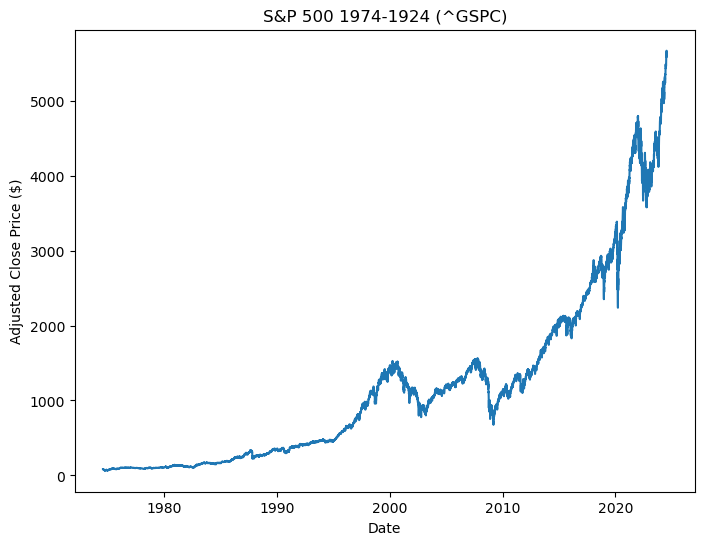

In [3]:
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(sp500_history['Date'], sp500_history['Adj Close**'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.title('S&P 500 1974-1924 (^GSPC)')
plt.show()

## II. Identify Trend 
Here we want to identify the overall market trend in the form
of a simple, closed-form analytical equation. 
We considered low order polynomial, exponential and logrithmic functions.
We assessed each based on fit and complexity using an information criterion.
Here we will use the Baysian Information Criteria (BIC) and 
adjusted r-squared value built into the statsmodel library.

We found that polynomials improved both the BIC and 
the adj r-squared value up to order four.
We expect worsening results due to numerical instability at order 5 and higher.
The fourth order polynomial captured about 97% of variability.  
Interestingly the exponental polynomial did nearly as well, 
at 95% of variability, with fewer than half the parameters.
The calculated ic value for the exponentail is not comparable 
due to the transformation of y prior to analysis.

For this work, we will consider the 4<sup>th</sup> order polynomial due to improved fit.
Since the BIC for order four is lower than that of order one, 
we do not belive the additional parameters added model complexity 
(primarily because there is so much data).
In addition, the following use of the fit is for interpolation 
and to remove any drift or trend that occurs over long time periods
and not for extrapolation, prediction or insight of mechinisim of drift.
However, future work may wish to consider the more simplisitic exponentail fit. 


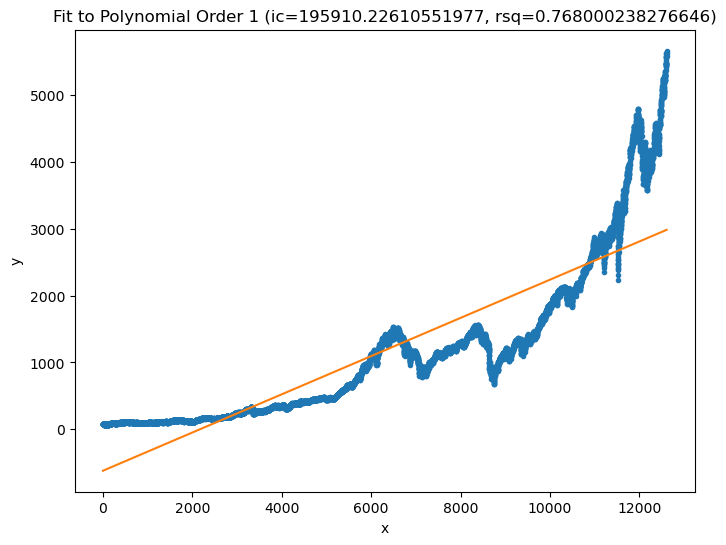

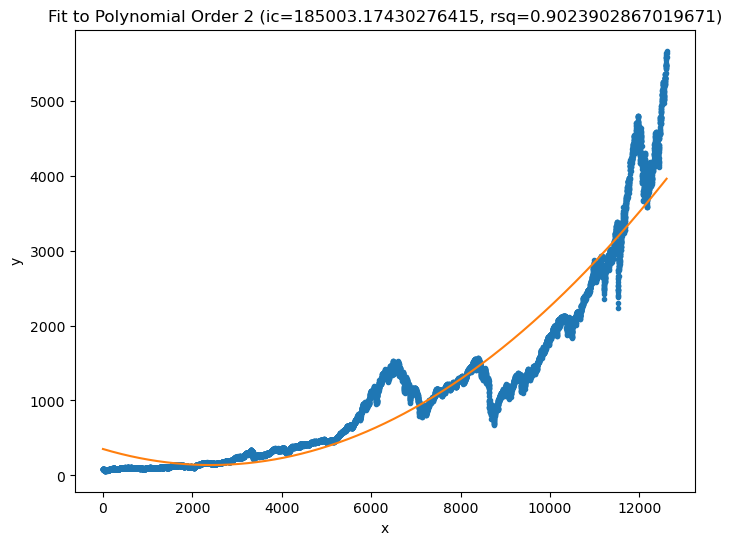

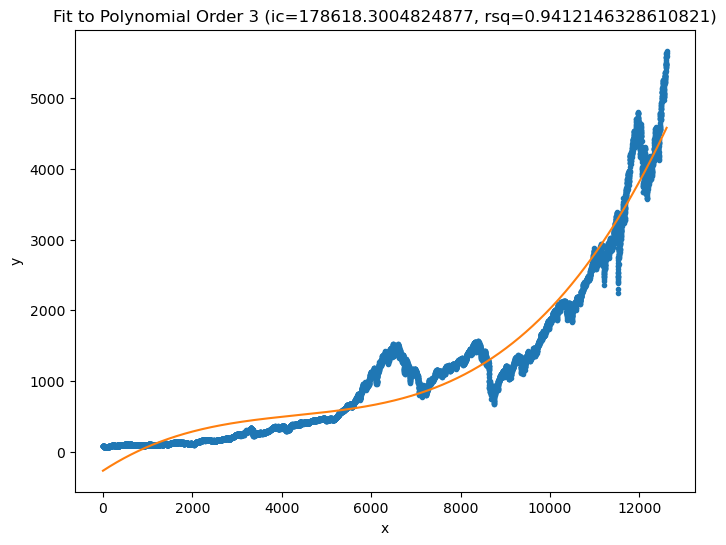

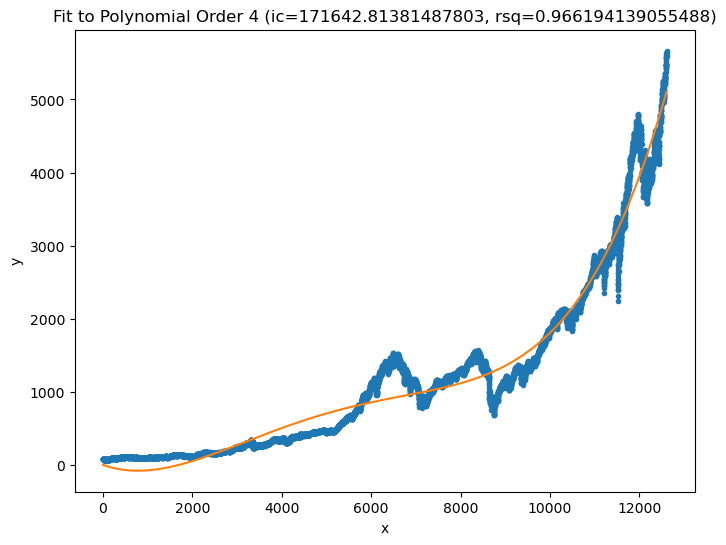

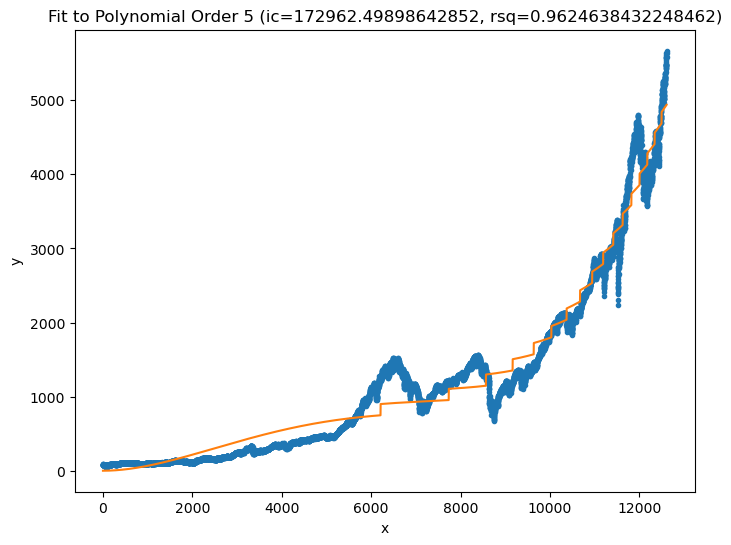

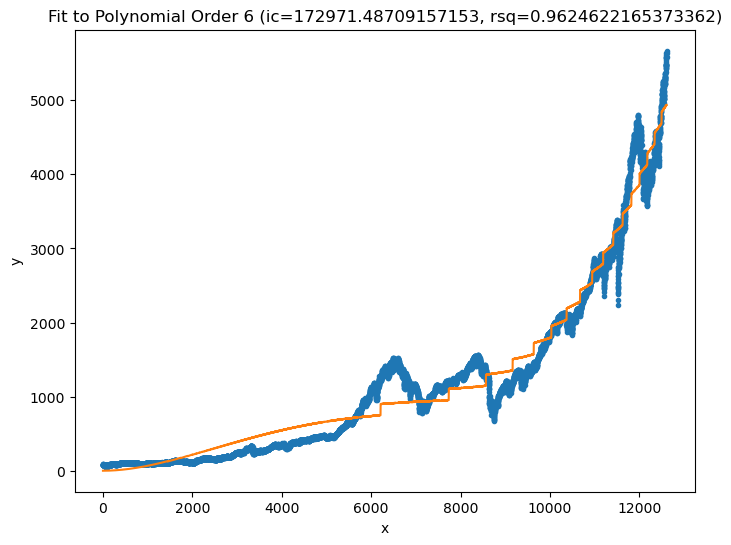

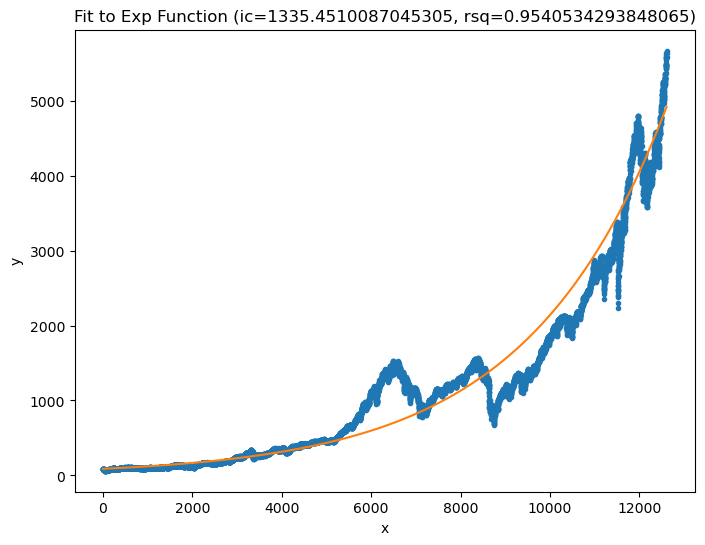

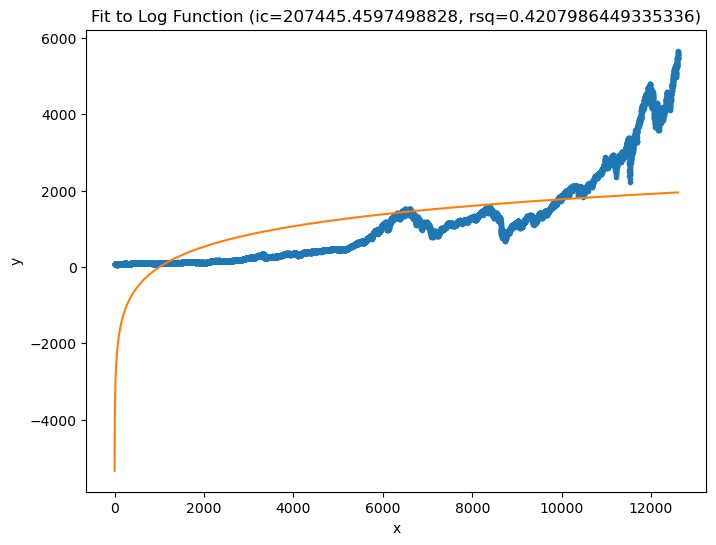

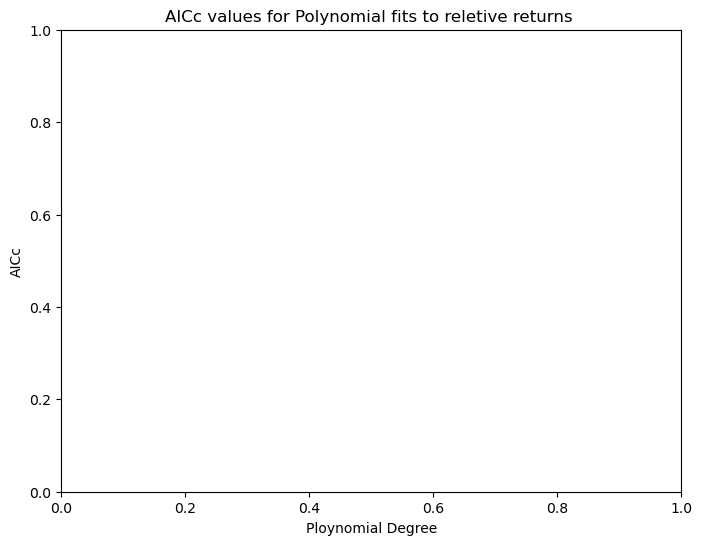

[195910.22610551977, 185003.17430276415, 178618.3004824877, 171642.81381487803, 172962.49898642852, 172971.48709157153, 1335.4510087045305, 207445.4597498828]


In [5]:

# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

##############

names = []
minIc = 1000
minIcIndex = -1
ics = []
rsqs = []

x = np.arange(len(sp500_history['Adj Close**']))
y = sp500_history['Adj Close**']



def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X).fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# Run through all poly deg models
for i in range(maxPolyOrder):
    polyOrder = i+1
    name = 'Polynomial Order '+str(polyOrder)
    names.append(name)

    # Create X matrix
    if polyOrder == 1:
        X = add_constant(x.reshape(-1, 1))
    else:
        X = np.c_[X, x**polyOrder]

    ic, rsq, yHat, model = run_model(X,y)

    # Hack to capture the chosen fit of order 4, added posthock
    if polyOrder == 4:
        yHat_final = yHat
    
    ics.append(ic)
    rsqs.append(rsq)
    
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    plt.plot(x, y,'.',x,yHat,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
    plt.show()


# Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
name = 'Exp Function'
names.append(name)

X = add_constant(x.reshape(-1, 1))
ic, rsq, yHatLog, model = run_model(X,np.log(y))
ics.append(ic)
rsqs.append(rsq)

## Hack to capture the chosen fit of order 4, added posthock
#yHat_final = np.exp(yHatLog)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,np.exp(yHatLog),'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Run for log function: y=A+Blog(x)
name = 'Log Function'
names.append(name)

X = add_constant(np.log(x+1).reshape(-1, 1))
ic, rsq, yHat, model = run_model(X,y)
ics.append(ic)
rsqs.append(rsq)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Plot AICcs for inspection
plt.figure(figsize=(8, 6))
#plt.plot(np.arange(30)+1, ics,'.')
plt.xlabel('Ploynomial Degree')
plt.ylabel('AICc')
plt.title('AICc values for Polynomial fits to reletive returns ')
plt.show()

print(ics)
    

## III. Sampling Frequency of Price
For any statistical analysis we have to determine how much time will pass
between t<sub>i</sub> and t_<sub>i+1</sub> in our data set.
In my experiance this is often arbitrarily determine, 
but here we will consider a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing there dependence
since a proper statistical analysis would require statistically independent samples.
To do this, we consider the price is based on both a 'drift' and a 'noise' term.
The drift is defined by the trend (Section II).
By subtracting the expected value based on this trend, 
we are left with the noise term.
To ensure the noise term is statistically independent, 
we will select a sampling rate such that each point in our time series 
is independent with a 95% confidence.
Ultimately this is done by considering the elapsed time for the 
auto-correlation function to drop to a 95% confidence level of zero.
Note, this assumes all dependence is related to time, 
which is supported by the results showig the correlation converges towards zero over time.

Interestingly, we found long time correlations in the ACF for the noise portion of this trend.
A similar result was found when considering the price point itself and 
when using the exponential as the trend for the drift.
We also ran an analogous, brute force calculation to confirm the findings.
Our hope was that that the function would remove any systemic behaviour.
That did not happen in this case.
There are statistical methods to investigate further, and more rigurously;
however, the are beyond the scope of this project.
In the next section, we will reapply the analysis to the return.



[1.         0.9963323  0.99318941 ... 0.07133199 0.07124161 0.0711642 ]


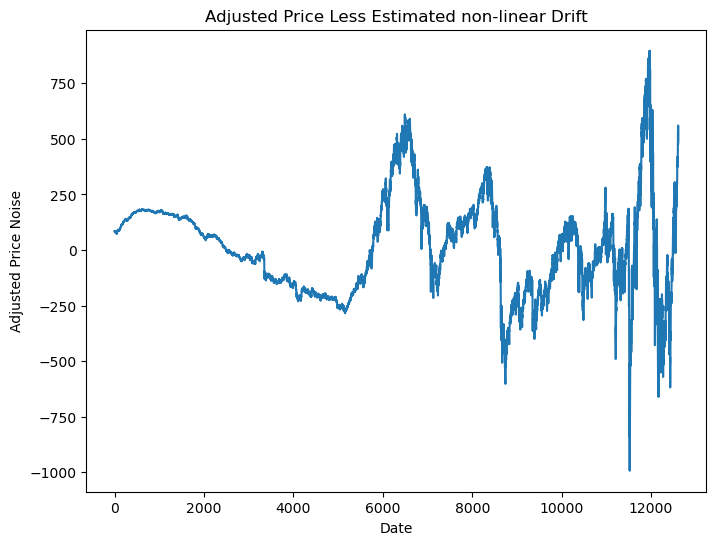

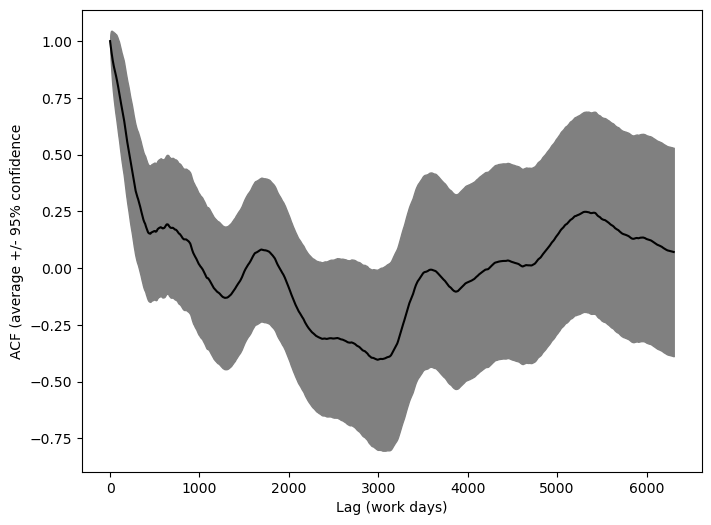

In [11]:

# Define the autocorr funciton
def acf(x,fracLag = 0.5):
    # Get auto corelation function for noise (with 68% confidence interval)
    n = len(x)
    # maximum lag considered is % of total 
    maxLag = int(fracLag*n)

    # Well accepted method
    acf, acfConf = stattools.acf(x,alpha=(1-0.95),nlags=maxLag)

#    # Rubber meets the road, brute force method to double check (long run time)
#    x = x - np.mean(x)
#    acf = np.zeros(maxLag)
#    acfConf = np.zeros((maxLag,2))
#    for delta in range(maxLag):
#        corr = np.array([])
#        for i in range(n):
#            indLag = i+delta
#            if indLag < n: 
#                corr = np.append(corr,x[i]*x[i+delta])
#        acf[delta] = np.mean(corr)
#        acfConf[delta,0] = acf[delta] + np.sqrt(np.var(corr)/len(corr))
#        acfConf[delta,1] = acf[delta] - np.sqrt(np.var(corr)/len(corr))
       

    return acf, acfConf
    
    
# Remove the drift 
# Recall that we previously dfined y as our target, adjusted closing price
# We also defined yHat_final as our prefered fit

yNoise = y-yHat_final

yNoise_ac, yNoise_acConf = acf(yNoise)
print(yNoise_ac)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Adjusted Price Less Estimated non-linear Drift')
plt.show()



# Plot the data for sanity check
plt.figure(figsize=(8, 6))
lag = np.arange(len(yNoise_ac))
plt.plot(lag, yNoise_ac,color='black')
plt.fill_between(lag, yNoise_acConf[:,0],yNoise_acConf[:,1],color='gray')
plt.xlabel('Lag (work days)')
plt.ylabel('ACF (average +/- 95% confidence')
#plt.title('')
plt.show()


## IV. Sampiling Frequency of Returns
Given the result above, we will consider the sampiling rate relavant to returns, not price.
We feel this may actually be a more important feature to look at for determining the 
meta parameter of sampiling rate as it relates to relavant statistical independance.

### i. Transform to Returns
Our final statistical analysis will be based on monthly returns. 
To simplify this we are considering 30 day periods from time t to t+30 days. 
Since stock is traded on weekdays and our time series only contains weekdays,
we are removing approximatly  2 weekends days per a 30 day month given 4.25 weeks each month.
As a matter of practice, we are considering relative returns.

[    0     1     2 ... 12605 12606 12607]
[  83.78   83.54   83.81 ... 5631.22 5667.2  5588.27]
[-0.10993077 -0.10282499 -0.12289703 ...  0.03092396  0.03797859
  0.04066327]
[ -9.21  -8.59 -10.3  ... 161.24 198.35 212.32]
[   22    23    24 ... 12583 12584 12585]


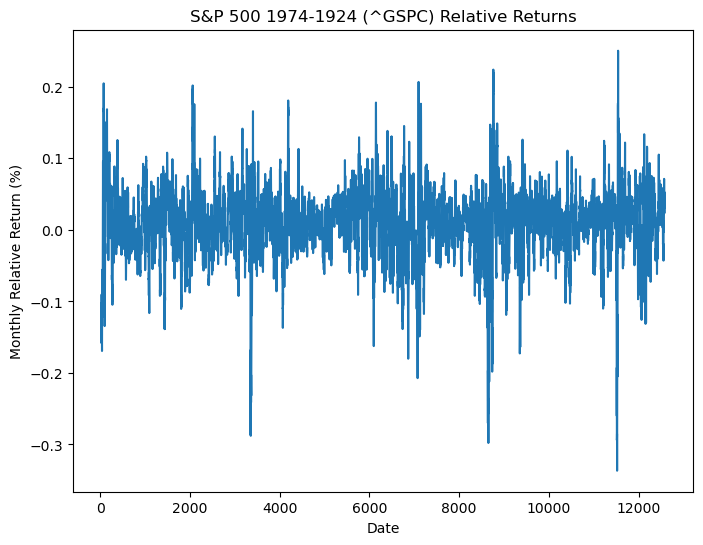

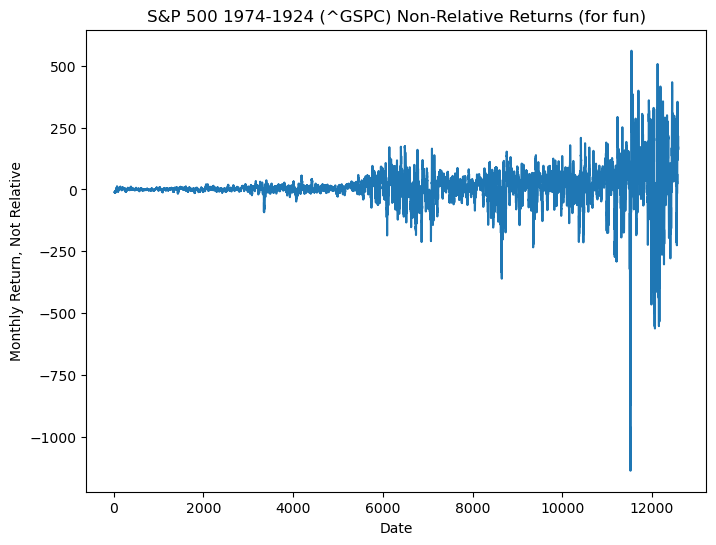

In [9]:
# Just to be sure we know whats what 
x = np.arange(len(sp500_history['Adj Close**']))
y = np.array(sp500_history['Adj Close**'])

print(x)
print(y)

# Open market days in a month: 30(days per month) - 4.25(weeks in 30 days) * 2(weekend days)
days = 30 - 8
n = len(y)-days

# calculate returns
yReturn = np.zeros(n-days)
yReturn_nonrel = np.zeros(n-days) #just for a fun note
xReturn = []
for i in range(n-days):
    yReturn[i] = (y[i+days] - y[i]) / y[i]
    yReturn_nonrel[i] = (y[i+days] - y[i])
    xReturn.append(x[i+days])

xReturn = np.array(xReturn)

# Show for sanity check
print(yReturn)
print(yReturn_nonrel)
print(xReturn)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn)
plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('S&P 500 1974-1924 (^GSPC) Relative Returns')
plt.show()

# Plot the non relative data for fun
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn_nonrel)
plt.xlabel('Date')
plt.ylabel('Monthly Return, Not Relative')
plt.title('S&P 500 1974-1924 (^GSPC) Non-Relative Returns (for fun)')
plt.show()

### ii. Autocorrelation Function
As in Section III, we caculated the ACF to determine the time need 
for samples to be reasonably considered statistically independent.
In this case we use the returns as determined above in Section IV.i.

We found the ACF to drop below zero after 21 days
and to follow closly to zero in an ocilitory pattern thereafter.
The upper bound on the 95% confidence interval does not pass zero
in the first part of the trijectory considered.

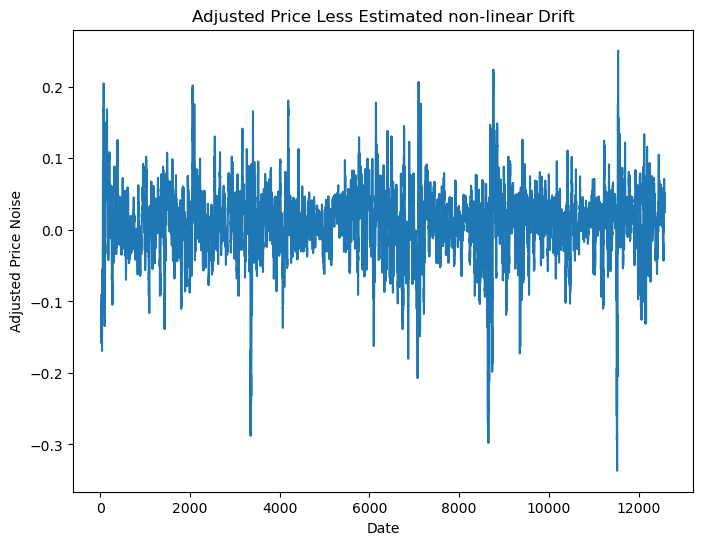

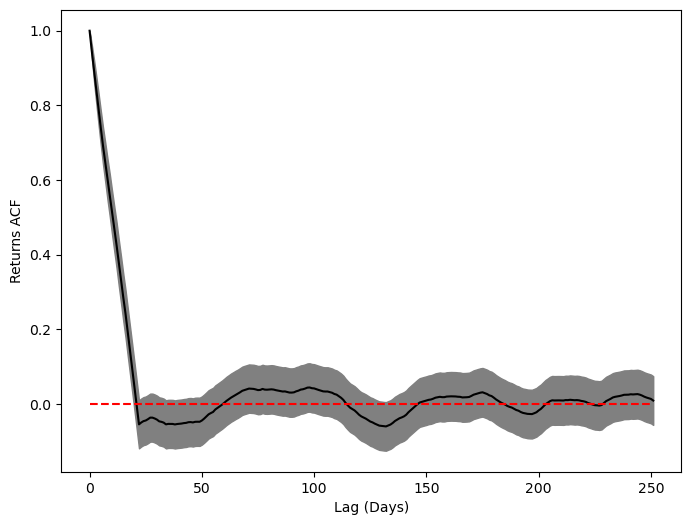

Return ACF
[ 1.00000000e+00  9.44550318e-01  8.92132225e-01  8.41295574e-01
  7.90127238e-01  7.39310899e-01  6.90631603e-01  6.46656446e-01
  6.01147887e-01  5.58818461e-01  5.13175758e-01  4.69245554e-01
  4.26447759e-01  3.78558629e-01  3.32984151e-01  2.85834644e-01
  2.42091981e-01  1.92603703e-01  1.43873601e-01  9.51707156e-02
  4.62461211e-02 -3.56099555e-03 -5.44215445e-02 -4.94957677e-02
 -4.57976259e-02 -4.40970506e-02 -4.05644834e-02 -3.63937817e-02
 -3.64429498e-02 -3.86892345e-02 -4.17556280e-02 -4.63485903e-02
 -4.76743859e-02 -4.98116604e-02 -5.44340594e-02 -5.31913021e-02
 -5.31346791e-02 -5.33338751e-02 -5.46217368e-02 -5.35288221e-02
 -5.29005172e-02 -5.22364534e-02 -5.10678504e-02 -5.04381990e-02
 -4.86942044e-02 -4.83249046e-02 -4.92814106e-02 -4.76349987e-02
 -4.74060996e-02 -4.75174772e-02 -4.41508806e-02 -3.91348359e-02
 -3.35354389e-02 -2.75827980e-02 -2.41929586e-02 -2.11647161e-02
 -1.44798171e-02 -1.03515185e-02 -5.95913597e-03 -1.68907795e-03
  3.31618475e-

In [20]:
# Recall the autocorr funciton is alreaded defined, acf()
# Recall the return is already calculated, yReturn, xReturn
    
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Adjusted Price Less Estimated non-linear Drift')
plt.show()    

# Calc autocorr
yReturn_ac, yReturn_acConf = acf(yReturn,fracLag=0.02)
lag = np.arange(len(yReturn_ac))


# Plot the data for sanity check
plt.figure(figsize=(8, 6))
lag = np.arange(len(yReturn_ac))
plt.plot(lag, yReturn_ac,color='black')
plt.plot(lag, np.zeros(len(lag)),'--',color='red')
plt.fill_between(lag,yReturn_acConf[:,0],yReturn_acConf[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('Returns ACF')
#plt.title('')
plt.show()
print('Return ACF')
print(yReturn_ac[:150])
print('Return ACF 95% Conf')
print(yReturn_acConf[:150])


### iii. Sampiling Frequency
Based on the results in Section IV.ii, 
we concluded that the sampiling frequency 
must be higher that 21 days and that, 
while some minor negative coerilations may exist,
there is no major deviation from zero over time.
To this end, we have decided to use 
42 days as the sampiling period for 
determining a 22 working day return (or ~30 day return or ~1 month return).


12608
301


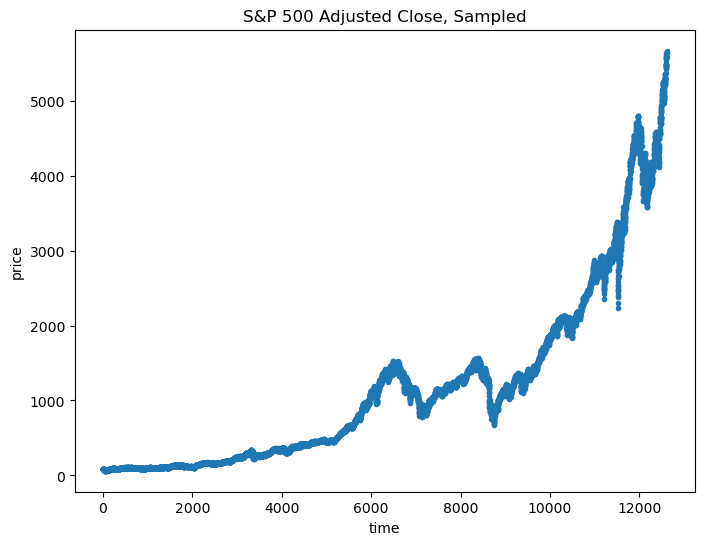

12564
300


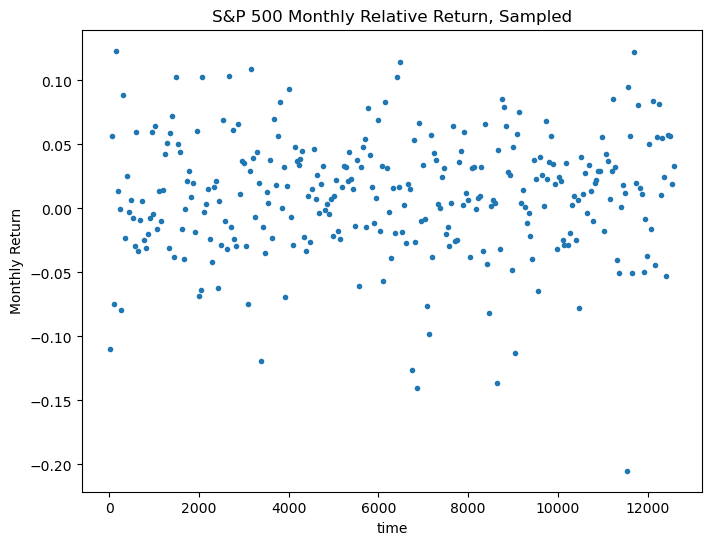

In [13]:
delta_return = 22
delta_sf = 42
n = len(sp500_history['Adj Close**'])
print(n)
inds = np.arange(0,n,delta_sf)

x = np.arange(len(sp500_history['Adj Close**']))
y = np.array(sp500_history['Adj Close**'])
x_samp = x[inds]
y_samp = y[inds]
print(len(x_samp))
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x,y,'.')
plt.xlabel('time')
plt.ylabel('price')
plt.title('S&P 500 Adjusted Close, Sampled')
plt.show()

# *** depending on returns from above section ***
n = len(xReturn)
print(n) 
inds = np.arange(0,n,delta_sf)
xReturn_samp = xReturn[inds]
yReturn_samp = yReturn[inds]
print(len(xReturn_samp))
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn_samp,yReturn_samp,'.')
plt.xlabel('time')
plt.ylabel('Monthly Return')
plt.title('S&P 500 Monthly Relative Return, Sampled')
plt.show()

## V. Identify Pricing Deviations
Given the sampiling frequency determined above, in Section IV.iii,
we will revisit the pricing data in order to 
recalculate systemic drift and pricing deviations (previously reffered to as noise). 

### i. Re-Assessing Trends for Systemic Drift 
Here we used the same basic code as in Section II, 
but we apply it to the properly sampled data to confirm.
We again found the 4th order polynomial to be the best fit.

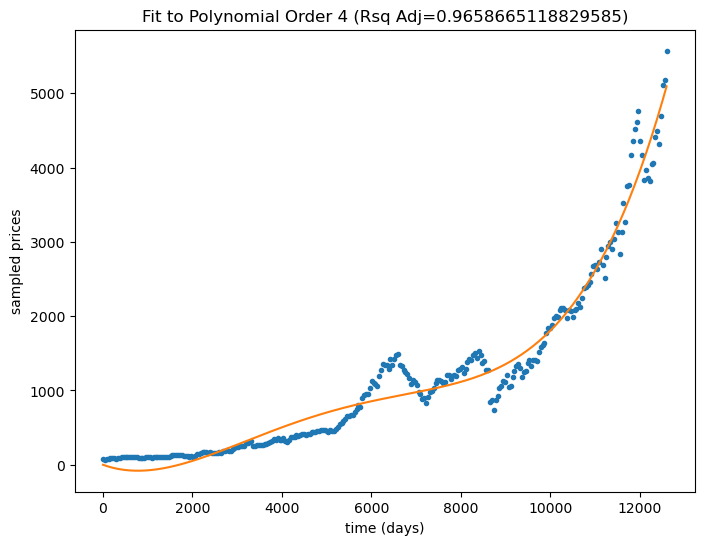

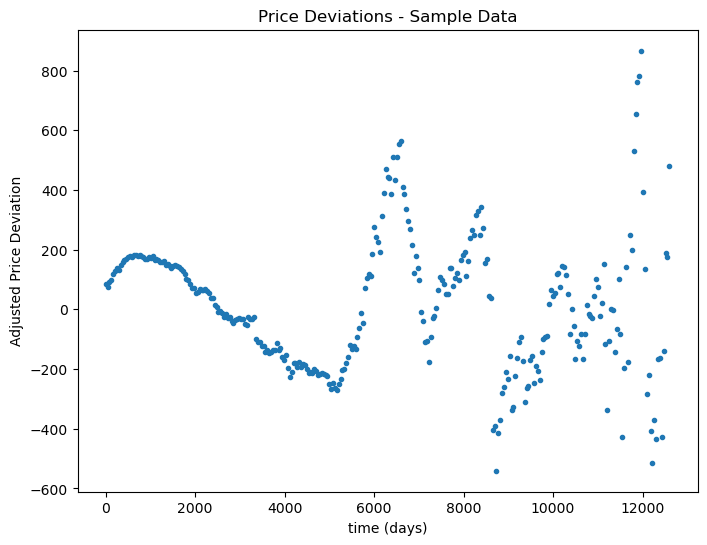

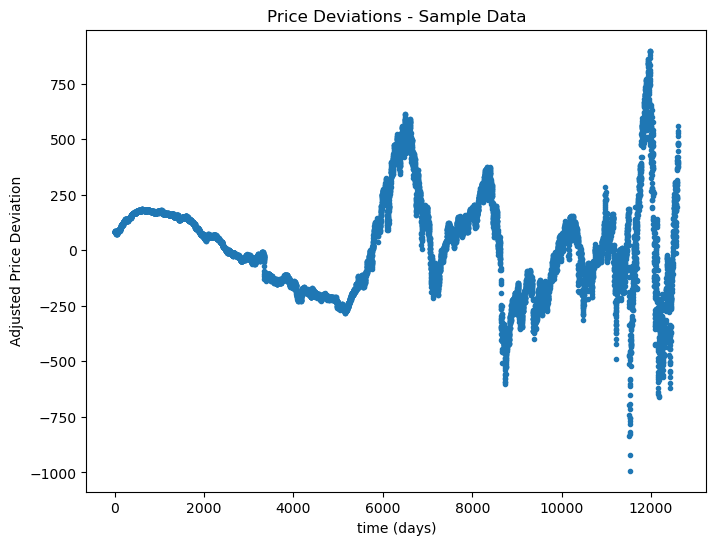

In [37]:

 
# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X).fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# given repeted use we are going to define a function for this

def pickSimpModel(x,y,maxPolyOrder):

    nameBest = ''
    modelBest = ''
    yHatBest = []
    rsqAdjBest = 0 
    # we decided to use adjusted r squared here because the ics
    # calculated in stats ols function are not comparable if a
    # variable transformation is done on y prior to the function
    # call, which is what we do in exp.
    # However, this should not be an issue given the small number 
    # of parameters for these models.
    if len(y) < maxPolyOrder*4: 
        print('Warning: Low obs to order, double check model selection criterion')

    # Run through all poly deg models
    for i in range(maxPolyOrder):
        polyOrder = i+1
        name = 'Polynomial Order '+str(polyOrder)

        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

        ic, rsqAdj, yHat, model = run_model(X,y)
        
        if rsqAdj > rsqAdjBest:
            rsqAdjBest = rsqAdj
            nameBest = name
            modelBest = model
            yHatBest = yHat
        
    


    ### Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
    name = 'Exp Function'

    X = add_constant(x_samp.reshape(-1, 1))
    ic, rsqAdj, yHatLog, model = run_model(X,np.log(y))
    
    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = np.exp(yHatLog)


    ### Run for log function: y=A+Blog(x)
    name = 'Log Function'

    X = add_constant(np.log(x_samp+1).reshape(-1, 1))
    ic, rsqAdj, yHat, model = run_model(X,y)

    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = yHat


    return rsqAdjBest, nameBest, modelBest, yHatBest



rsqAdjBest, nameBest, modelBest, yHatBest = pickSimpModel(x_samp,y_samp,maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, y_samp,'.',x_samp,yHatBest,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+nameBest+' (Rsq Adj='+str(rsqAdjBest)+')')
plt.show()

################

yNoise = y_samp-yHatBest

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, yNoise, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - Sample Data')
plt.show()

x = np.arange(len(sp500_history['Adj Close**']))
y = sp500_history['Adj Close**']


## Deviations in full data set
# just in-case we want to look at it but
# using the model built on properly spaced sample data

# recall that we did some manipulation before calling the model
# now we need to do it again
# in the future we should write in a function to solve for this issue
# to avoid human error
for i in range(4):
        polyOrder = i+1
        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

yNoise_full = y-modelBest.predict(X)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise_full, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - Sample Data')
plt.show()
    

### ii. Use Robust Statistics to Define Deviations
Using median and absolute deviation as a robust analogue to 
the sample mean and standard deviation,
which are commonly used for expected return and volatility metrics. 
Here we are defining 1, 2 and 3 abs devs as abnormal, semi-rare and rare events.

In [15]:
#  CDefine the Thresholds *USER SET*
def thresh(x):
    frac_ab = 0.68 # abnormal event - equivlant to 1 stdev 
    frac_sr = 0.95 # semi-rare event - equivlant to 2 stdev
    frac_r = 0.995 # rare event
    n = len(x)
    x_sorted = np.sort(x)

    thresh_ab = x_sorted[int(n*frac_ab)]
    thresh_sr = x_sorted[int(n*frac_sr)]
    thresh_r = x_sorted[int(n*frac_r)]
    return thresh_ab, thresh_sr, thresh_r

# We are working with robust stats so shift to the median 
yNoise = yNoise - np.median(yNoise)

# for deviations, we dont care if they are positive or negative
yDev = np.abs(yNoise)

# Caclulat threshold values
thresh_ab, thresh_sr, thresh_r = thresh(yDev)

# Print for sanity check
n = len(yDev)
print(n)
print(str(thresh_ab)+' - '+str(int(n-.68*n)))
print(str(thresh_sr)+' - '+str(int(n-.95*n)))
print(str(thresh_r)+' - '+str(int(n-.995*n)))


301
184.56889899470076 - 96
434.60569912035317 - 15
778.0116945841426 - 1


## VI. Event and Lengths
Here, we are concerned with events that are less frequent.
When an deviation is identified as deviation >= event threshold 
it is marked as an event and is considered to continue, 
proceeding over all consecutive time points, 
until it drops below the event threshold.
This determines the overall events length.

We found 16 abnormal events 
(defined as 33% of most extreme price deviations from an expected trend)
with a median of 126 open market days.
This streches from about two months to nearly four years.
The length of semi-rare and rare deveiation events reduces drastically
before trending back to expected values.
Based on these numbers it would be unwise to for investors 
to wait at least six months before any major changes 
(beyond rebalancing) on ones portfolio even in the face 
of sudden, seemingly unexpected, market change.



Threshold: 184.56889899470076
Number of Events: 16
Median Event Length: 126.0
Event Lengths:
[  42   42   42   84   84  126  126  126  168  252  336  336  378  882
 1008]
Total Time:
4032


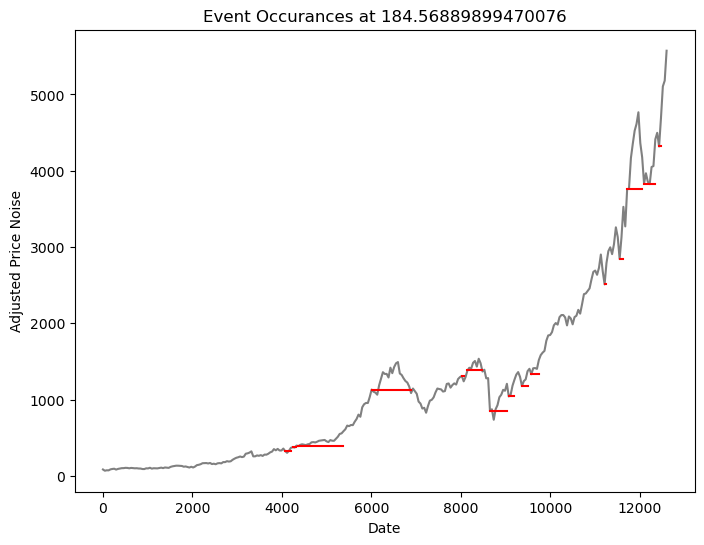

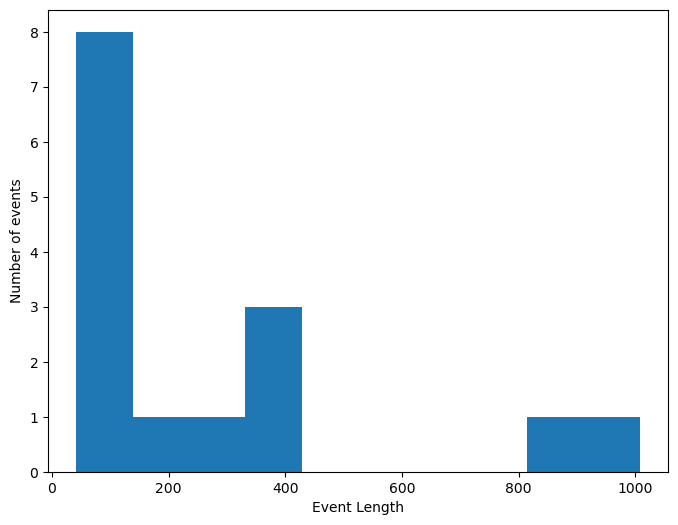

Threshold: 434.60569912035317
Number of Events: 8
Median Event Length: 42.0
Event Lengths:
[ 42  42  42  42 126 126 210]
Total Time:
630


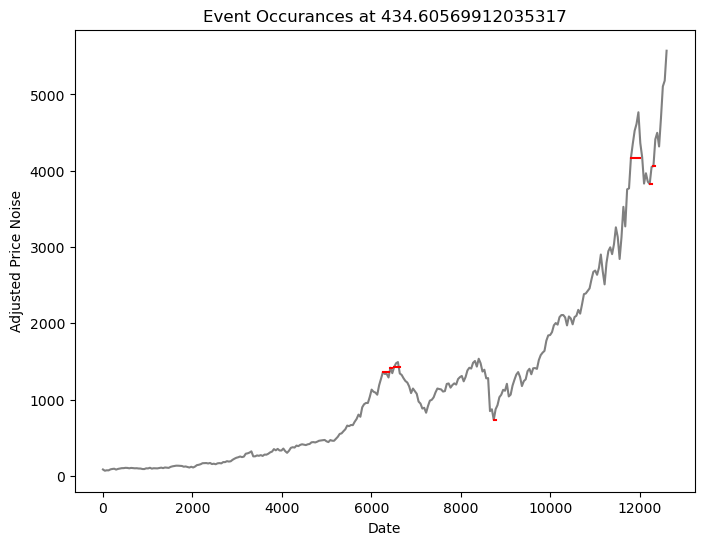

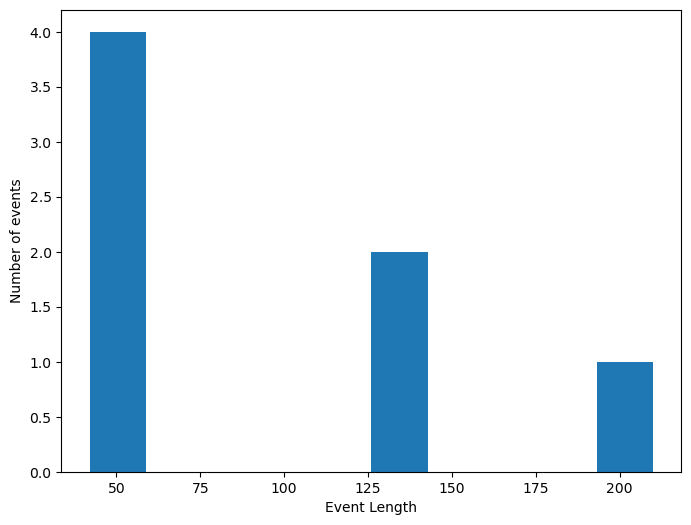

Threshold: 778.0116945841426
Number of Events: 1
Median Event Length: 84.0
Event Lengths:
[84]
Total Time:
84


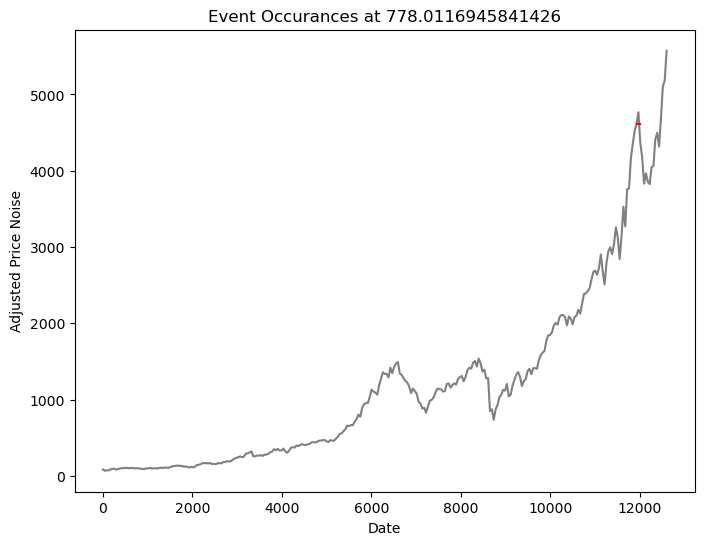

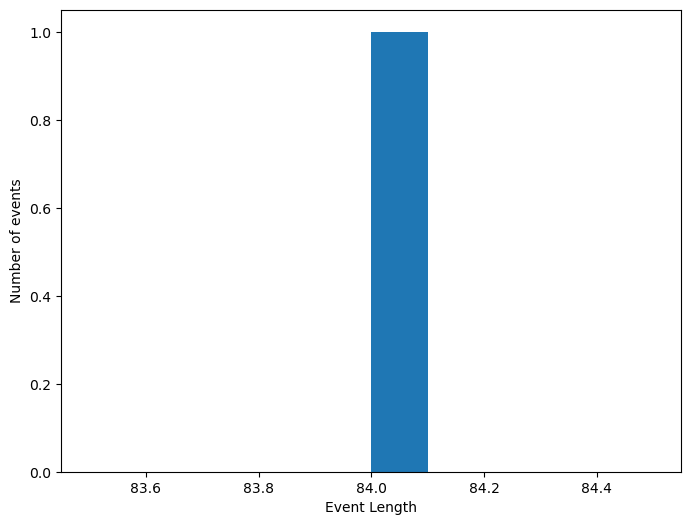

In [73]:
# Define event finder

def flagEvents(time,value,thresh):
    n = len(time)
    event_time=[]
    event_ind=[]
    event_length=[]
    started=False 
    for i in range(n):
        if (value[i]>=thresh) and (started==False):
            started=True
            event_time.append(time[i])
            event_ind.append(i)

            start_time=time[i]
        elif (value[i]<thresh) and (started==True):
            started=False
            end_time=time[i]
            event_length.append(end_time-start_time)
            
    return event_time, event_length, event_ind

for thresh in [thresh_ab, thresh_sr, thresh_r]:
    event_time, event_length, event_ind= flagEvents(x_samp,yDev,thresh)
    
    print('Threshold: '+str(thresh))
    print('Number of Events: '+str(len(event_time)))
    print('Median Event Length: '+str(np.median(event_length)))
    print('Event Lengths:')
    print(np.sort(event_length))
    print('Total Time:')
    print(np.sum(event_length))
    inds = np.array(event_ind)
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    #plt.plot(x_samp, y_samp,'_',x_samp[inds],y_samp[inds], '.')
    plt.plot(x_samp, y_samp,color='gray')
    for i in range(len(inds)):
        ind = inds[i]
        event_x0 = x_samp[ind]
        if i == len(event_length): # if last event has not finished, it wont have a length yet
            event_xt = x_samp[-1] # we are setting these events to end at the time frame end
        else:
            event_xt = event_x0 + event_length[i]
        event_y = y_samp[ind]
        plt.plot([event_x0,event_xt],[event_y,event_y],color='red')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price Noise')
    plt.title('Event Occurances at ' + str(thresh))
    plt.show()
    plt.figure(figsize=(8, 6))

    plt.hist(event_length)
    plt.xlabel('Event Length')
    plt.ylabel('Number of events')
    plt.title('')
    plt.show()



# *** Consider doing the full time course, will need to re assess the yHats, which means we needed to save the modle from before




## VII. Portfolio Holding Time
A simple analysis was done regarding the average portfolio return 
depending on portfolio hold time.
We suggest that the longer a portfolio is held, the high the return.
We looked at relative returns in one month increments from zero to over 15 years.
Averages were taken over the full 50 year S&P time course used above.
There was a clear linear dependance with a slope of about 0.17 or 17% increase per year.
The 95% confidence interval does suggest wide variation depending on the exact timing 
of when a portfolio is started or stopped.
It is possible for a few instances a portfolio can lose money even after 10 year,
but there many more instances of portfolios increasing above 200%.
Although stats become worse from longer time periods, it was suggestive
that portfolios nearly always increase in value after 13 years - some as high as 400%.
Our suggestion is that basic portfolio managment is a good to great strategy for a hold period of 10 to 13+years.

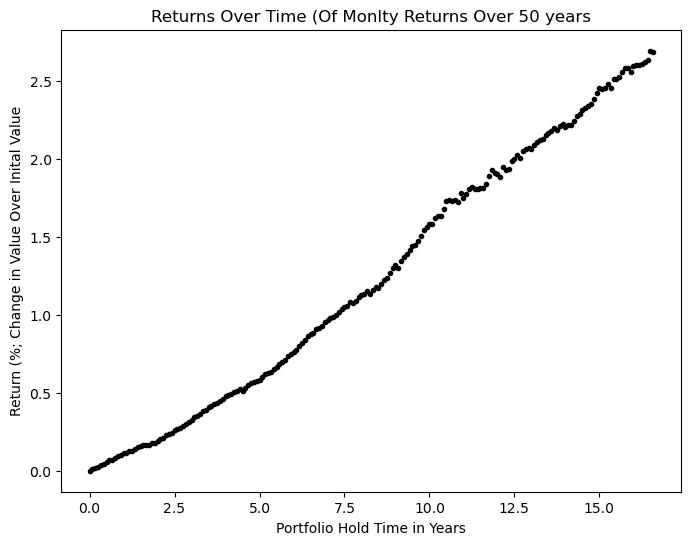

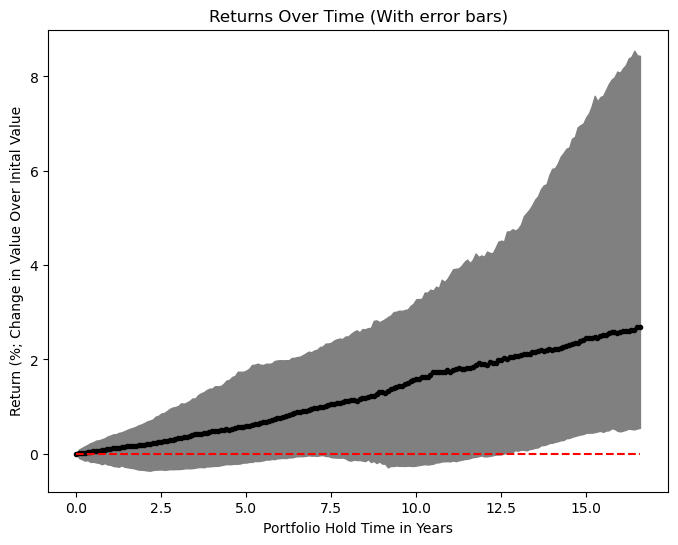

In [71]:
def returnFunc(a,b):
    return (b-a)/a
    
def calcRunningReturns(x):
    
    n = len(x)
    returns = np.array([])
    confup = np.array([])
    confdn = np.array([])
    lags = np.array([])
    
    for lag in range(int(n/3)):
        
        temp = []
        for j in range(0,n-lag,1):
            temp.append(returnFunc(x[j],x[j+lag]))
            
        temp = np.sort(temp)
        m = len(temp)
        indUp = int(m/2) + int(m*.475)
        indDn = int(m/2) - int(m*.475)

        returns = np.append(returns,np.median(temp))
        confup = np.append(confup,temp[indUp])
        confdn = np.append(confdn,temp[indDn])
        lags = np.append(lags,lag)
        
    return returns, np.c_[confup,confdn], lags

y = sp500_history['Adj Close**'].to_numpy()
# monthly
inds = np.array(range(0,len(y),21))


returns, conf, lags = calcRunningReturns(y[inds])



plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
#plt.fill_between(lags/12,stDev*2+returns,returns-stDev*2,color='gray')
plt.xlabel('Portfolio Hold Time in Years')
plt.ylabel('Return (%; Change in Value Over Inital Value')
plt.title('Returns Over Time (Of Monlty Returns Over 50 years')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
plt.plot(lags/12,returns*0,'--',color='red')
plt.fill_between(lags/12,conf[:,0],conf[:,1],color='gray')
plt.xlabel('Portfolio Hold Time in Years')
plt.ylabel('Return (%; Change in Value Over Inital Value')
plt.title('Returns Over Time (With error bars)')
plt.show()

## Application for Managment  
Can we use the sampling rate here for portfolio analysis in general?
Does Event Length (EL) help us determine a sampling period for portfolio analysis in general?
Does EL help us determine a hold or portfolio re-balancing strategy?